In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import seaborn as sns
import json
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import gc

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']

print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
sys.path.append('../detector/')
from DeepFakeDetector import DeepFakeDetector
sys.path.append('../util/')

/home/joni/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Copy the facenet pretrained weights to cache
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-logits.pth /tmp/.cache/torch/checkpoints/vggface2_DG3kwML46X.pt
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-features.pth /tmp/.cache/torch/checkpoints/vggface2_G5aNV2VSMn.pt

In [5]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,-9.223372e+18,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,-9.223372e+18,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,-9.223372e+18,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,-9.223372e+18,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",NaN,ptpwappdyx.mp4,2020-02-17
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,1.000000e+00,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17


In [6]:
# Get all test videos
filenames = []
for filename in Path(video_path).rglob('*.mp4'):
    filenames.append(filename)
print(len(filenames))

119146


In [7]:
n_first_frames = 10
n_spaced_frames = 10
pretrained_paths = '../pretrained_models/'
models_root_dir = '../kaggle_datasets/deepfake_2020_03_09/'

deepFakeDetector = DeepFakeDetector(deepfake_models_directory=models_root_dir,
                                    third_party_models_directory=pretrained_paths,
                                    n_first_frames=n_first_frames,
                                    n_spaced_frames=n_spaced_frames)

cuda:0
Loaded video frame sampler.
Loaded face detectors.
Loaded pytorch facenet face embeddings model.
Loaded 2 small face classifier and 2 large face classifier models.
RecurrrentModelConfig: len_sequence 5, min_frame_index 10, max_frame_index 16
RecurrrentModelConfig: len_sequence 5, min_frame_index 10, max_frame_index 16
Loaded 2 face sequence classifier models.
Loaded 5 second level xgb classifier models and 5 logistic regression models.
##################################################
DeepFakeDetector v.0.5.2
Sample 10 first frames and 10 spaced frames.
Number of max retries is 5
On error cases, predict 0.5
##################################################


In [8]:
featNames = deepFakeDetector.GetFeatureNames()
print("Num features: " + str(len(featNames)))
featNames

Num features: 124


array(['small_face_clf_mean_0_original_first', 'small_face_clf_max_0_original_first',
       'small_face_clf_std_0_original_first', 'small_face_clf_median_0_original_first', ...,
       'seq_clf_len-5_start-10_1_zoom_mean', 'seq_clf_len-5_start-10_1_zoom_max', 'seq_clf_len-5_start-10_1_zoom_std',
       'seq_clf_len-5_start-10_1_zoom_median'], dtype='<U48')

We have saved the two-person cases from validation set for testing

In [9]:
df = df[df['isVal']==True]
df = df[df['cv_fold']<999]
df = df[df['person_count']==2]
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
26,eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...",pfvywdrbno.mp4,2020-02-17
99,oqglliennm.mp4,FAKE,2nd_level,True,1,2,2.0,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",fqeebgwwfs.mp4,2020-02-17
104,rxhqujqzwh.mp4,FAKE,2nd_level,True,1,2,2.0,1.0,"[2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...",ydqovcxvum.mp4,2020-02-17
109,flxsxcgfkz.mp4,FAKE,2nd_level,True,1,2,1.0,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",zakfeyskak.mp4,2020-02-17
140,eskrzejqxk.mp4,FAKE,2nd_level,True,0,2,2.0,1.0,"[1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...",xylxjtdsdq.mp4,2020-02-17


In [10]:
print(len(df))

2770


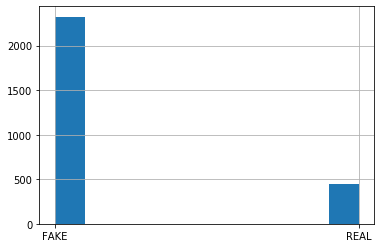

In [11]:
df.label.hist()

In [12]:
fake_real_ratio = len(df[df['label']=='FAKE']) / len(df[df['label']=='REAL'])
print('There are {0:.2} times more fakes'.format(fake_real_ratio))

There are 5.2 times more fakes


In [13]:
df = df.set_index('index')
df.head()

,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
index,,,,,,,,,,,
eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...",pfvywdrbno.mp4,2020-02-17
oqglliennm.mp4,FAKE,2nd_level,True,1,2,2.0,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",fqeebgwwfs.mp4,2020-02-17
rxhqujqzwh.mp4,FAKE,2nd_level,True,1,2,2.0,1.0,"[2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...",ydqovcxvum.mp4,2020-02-17
flxsxcgfkz.mp4,FAKE,2nd_level,True,1,2,1.0,1.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",zakfeyskak.mp4,2020-02-17
eskrzejqxk.mp4,FAKE,2nd_level,True,0,2,2.0,1.0,"[1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...",xylxjtdsdq.mp4,2020-02-17


In [14]:
from tqdm.notebook import tqdm as tqdm
import random
random.seed(2020)

#raw lists
preds_fake = []
preds_real = []

keys=df.index.values
feat_len = featNames.shape[0]

for i, filename in enumerate(tqdm(filenames)):
       
    plain_name = str(filename).split('/')[len(str(filename).split('/'))-1]
    
    if plain_name not in keys:
        continue
    
    is_fake = True if df.at[plain_name,'label'] == 'FAKE' else False
    
    #sample fakes the same amount as reals and sample randomly
    if is_fake and random.randint(0,int(round(10*fake_real_ratio))) >= 10:
        continue
    
    split = df.at[plain_name,'cv_fold']
    try:
        pred = deepFakeDetector.Predict(str(filename), handleErrors=False)
        if is_fake:
            preds_fake.append(pred)
        else:
            preds_real.append(pred)
    except:
        print("Error with " + str(filename) + ' - ' + str(i))
        continue

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_06/dfdc_train_part_6/xzppwruzpq.mp4 - 15692
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_06/dfdc_train_part_6/xfimbeeqma.mp4 - 15849
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_22/svguwviycd.mp4 - 52070
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_23/jchsrvcboi.mp4 - 53454
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/rurhyzsnyi.mp4 - 110422
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/uhzkiwaftk.mp4 - 110650
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/fybfybjntb.mp4 - 111709
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/gwmpjvzjug.mp4 - 111805
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/hrrrvetfgu.mp4 - 111877
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_47/ihceabkzlk.mp4 - 11192

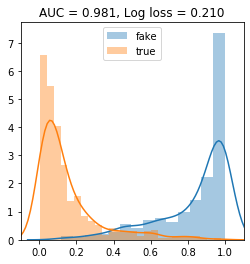

In [15]:
import matplotlib.axes
from sklearn.metrics import roc_auc_score, log_loss

def getAuc(fake_list, real_list):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    return roc_auc_score(true_labels,pred_labels)

def getLogLoss(fake_list, real_list, eps=1e-6):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    # epsilon clip to avoid nans
    pred_labels = np.clip(pred_labels,eps,1-eps)
    return log_loss(true_labels,pred_labels)

auc = getAuc(preds_fake, preds_real)
logloss = getLogLoss(preds_fake, preds_real)
f, ax = plt.subplots(1,1,figsize=(4,4))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('AUC = {0:.3f}, Log loss = {1:.3f}'.format(auc,logloss))
ax.set_xlim(-0.1,1.1)
#ax.set_ylim(0,5)
ax.legend()
plt.show()

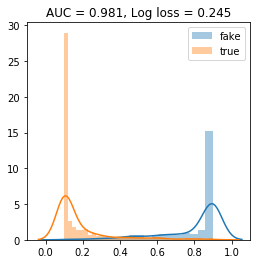

In [16]:
eps = 0.1
preds_fake_clipped = np.clip(np.array(preds_fake),eps,1-eps).tolist()
preds_real_clipped = np.clip(np.array(preds_real),eps,1-eps).tolist()

auc = getAuc(preds_fake_clipped, preds_real_clipped)
logloss = getLogLoss(preds_fake_clipped, preds_real_clipped)
f, ax = plt.subplots(1,1,figsize=(4,4))
sns.distplot(preds_fake_clipped, ax=ax, label='fake')
sns.distplot(preds_real_clipped, ax=ax, label='true')
ax.set_title('AUC = {0:.3f}, Log loss = {1:.3f}'.format(auc,logloss))
ax.set_xlim(-0.1,1.1)
#ax.set_ylim(0,5)
ax.legend()
plt.show()